# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [1]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [2]:
# Import required libraries
import os
import json
import gradio as gr
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import display

In [3]:
# Load environment variables from .env file
load_dotenv(override=True)

# API keys from environment
openai_api_key = os.getenv('OPENAI_API_KEY')
ollama_base_url = os.getenv('OLLAMA_BASE_URL')
ollama_api_key = os.getenv('OLLAMA_API_KEY')

# Verify API keys
if openai_api_key:
    print(f" OpenAI API Key loaded: {openai_api_key[:8]}...")
else:
    print(" OpenAI API Key not set")

if ollama_base_url:
    print(f" Ollama configured at: {ollama_base_url}")
else:
    print(" Ollama not configured")

 OpenAI API Key loaded: sk-proj-...
 Ollama configured at: http://192.168.80.200:11434


In [4]:
# Initialize OpenAI client (for chat, images, and audio)
openai_client = OpenAI(api_key=openai_api_key)

# Model configurations for OpenAI (most economical options)
OPENAI_CHAT_MODEL = "gpt-4o-mini"        # $0.15/$0.60 per 1M tokens
OPENAI_IMAGE_MODEL = "dall-e-3"          # ~$0.04 per image
OPENAI_TTS_MODEL = "tts-1"               # $15 per 1M characters (cheaper than tts-1-hd)

print(f" OpenAI client initialized")
print(f"   Chat Model: {OPENAI_CHAT_MODEL}")
print(f"   Image Model: {OPENAI_IMAGE_MODEL}")
print(f"   TTS Model: {OPENAI_TTS_MODEL}")

 OpenAI client initialized
   Chat Model: gpt-4o-mini
   Image Model: dall-e-3
   TTS Model: tts-1


In [6]:
# Initialize Ollama client (uses OpenAI-compatible API)
ollama_client = OpenAI(
    base_url=f"{ollama_base_url}/v1",
    api_key=ollama_api_key
)

# Model configuration for Ollama (best Tool support from day4 testing)
OLLAMA_CHAT_MODEL = "qwen3-coder:480b-cloud"  # FREE - Confirmed Tool support

print(f" Ollama client initialized")
print(f"   Chat Model: {OLLAMA_CHAT_MODEL}")
print(f"   Note: Ollama doesn't support image/audio generation natively")

 Ollama client initialized
   Chat Model: qwen3-coder:480b-cloud
   Note: Ollama doesn't support image/audio generation natively


In [7]:
def artist(city):
    image_response = openai_client.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

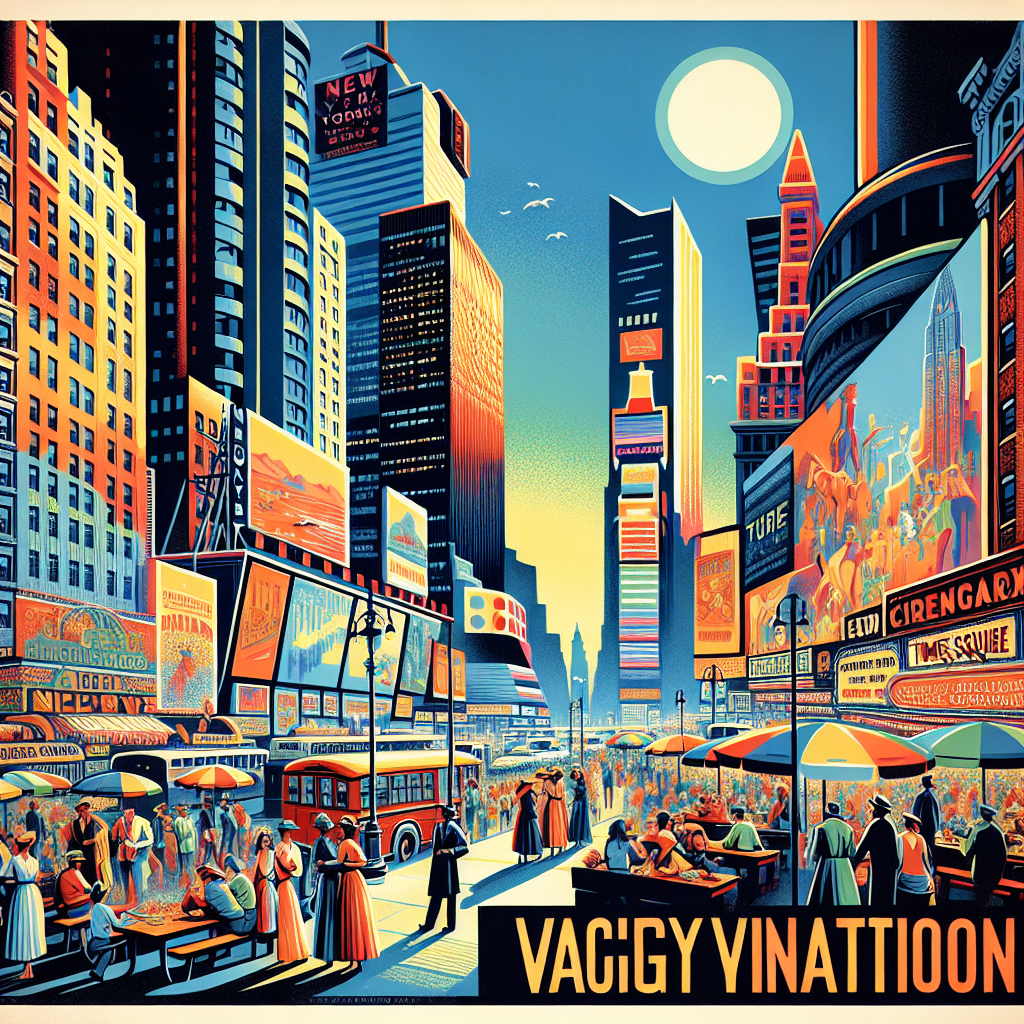

In [7]:
image = artist("New York City")
display(image)

### Nueva etapa: Audio/TTS (Text-to-Speech)

Ahora vamos a agregar generación de voz para que el asistente pueda "hablar" las respuestas.

In [8]:
# OpenAI TTS - Opción 1: tts-1 (más económico)
def talker(message):
    """
    Generate speech using OpenAI TTS
    Cost: $15 per 1M characters (tts-1) vs $30/1M (tts-1-hd)
    """
    response = openai_client.audio.speech.create(
        model=OPENAI_TTS_MODEL,  # "tts-1" - más barato
        voice="onyx",    # Options: alloy, echo, fable, onyx, nova, shimmer
        input=message
    )
    return response.content

In [13]:
# Test OpenAI TTS
talker("Hello! Welcome to New York City.")
audio_content = talker("Hello! Welcome to New York City.")
print(f"Audio generated: {len(audio_content)} bytes")

# Save to file to listen
with open("test_audio_openai.mp3", "wb") as f:
    f.write(audio_content)
print("Saved to test_audio_openai.mp3")

Audio generated: 38400 bytes
Saved to test_audio_openai.mp3


In [9]:
# Install: pip install pyttsx3
# For Google TTS: pip install gtts

def talker_local_pyttsx3(message):
    """
    Generate speech locally using pyttsx3 (FREE - offline)
    Quality: Basic but functional
    """
    try:
        import pyttsx3
        engine = pyttsx3.init()
        
        # Save to file
        output_file = "audio_local.mp3"
        engine.save_to_file(message, output_file)
        engine.runAndWait()
        
        # Read file content
        with open(output_file, "rb") as f:
            return f.read()
    except ImportError:
        print(" Install: pip install pyttsx3")
        return None

In [ ]:
talker_local_pyttsx3("Hello! Welcome to New York City.")

In [10]:
def talker_local_gtts(message):
    """
    Generate speech using Google TTS (FREE - requires internet)
    Quality: Better than pyttsx3, similar to basic cloud TTS
    """
    try:
        from gtts import gTTS
        from io import BytesIO
        
        # Generate speech
        tts = gTTS(text=message, lang='es')  # Change 'es' to 'en' for English
        
        # Save to BytesIO
        audio_fp = BytesIO()
        tts.write_to_fp(audio_fp)
        audio_fp.seek(0)
        
        return audio_fp.read()
    except ImportError:
        print(" Install: pip install gtts")
        return None

In [41]:
# Test gTTS - Generate and save audio
audio_gtts = talker_local_gtts("Hello! Welcome to New York City.")

if audio_gtts:
    print(f" Audio generated: {len(audio_gtts)} bytes")
    
    # Save to file to listen
    with open("test_audio_gtts.mp3", "wb") as f:
        f.write(audio_gtts)
    print(" Saved to test_audio_gtts.mp3")
    print("You can now download and play this file")
else:
    print(" Failed to generate audio")

 Audio generated: 25536 bytes
 Saved to test_audio_gtts.mp3
You can now download and play this file


In [15]:
# Install Coqui TTS: pip install TTS

# Available voices/models for Coqui TTS
COQUI_VOICES = {
    # === LIGHTWEIGHT MODELS (Recommended for notebooks) ===
    "tacotron2_en": "tts_models/en/ljspeech/tacotron2-DDC",      # ~100MB - Female English (FASTEST)
    "tacotron2_es": "tts_models/es/mai/tacotron2-DDC",           # ~100MB - Female Spanish
    "glow_tts_en": "tts_models/en/ljspeech/glow-tts",            # ~120MB - Female English (good quality)
    
    # === MEDIUM MODELS ===
    "vits_en": "tts_models/en/ljspeech/vits",                    # ~200MB - Better quality
    "vits_es": "tts_models/es/css10/vits",                       # ~200MB - Spanish better quality
    
    # === HEAVY MODELS (NOT RECOMMENDED for notebooks) ===
    "jenny": "tts_models/en/jenny/jenny",                        # 🔴 1.6GB - Very high quality (TOO HEAVY)
    "vctk": "tts_models/en/vctk/vits",                           # 🔴 ~800MB - Multiple speakers
}

# Print available voices with size info
print("🎤 Available Coqui TTS Voices:")
print("\n✅ LIGHTWEIGHT (Recommended):")
print("  - tacotron2_en: ~100MB - Female English (fastest)")
print("  - tacotron2_es: ~100MB - Female Spanish")
print("  - glow_tts_en: ~120MB - Female English (good quality)")
print("\n⚠️ MEDIUM:")
print("  - vits_en: ~200MB - Better quality")
print("  - vits_es: ~200MB - Spanish better quality")
print("\n🔴 HEAVY (Avoid in notebooks):")
print("  - jenny: 1.6GB - Very high quality (TOO HEAVY)")
print("  - vctk: ~800MB - Multiple speakers")

🎤 Available Coqui TTS Voices:

✅ LIGHTWEIGHT (Recommended):
  - tacotron2_en: ~100MB - Female English (fastest)
  - tacotron2_es: ~100MB - Female Spanish
  - glow_tts_en: ~120MB - Female English (good quality)

⚠️ MEDIUM:
  - vits_en: ~200MB - Better quality
  - vits_es: ~200MB - Spanish better quality

🔴 HEAVY (Avoid in notebooks):
  - jenny: 1.6GB - Very high quality (TOO HEAVY)
  - vctk: ~800MB - Multiple speakers


In [16]:
def talker_coqui(message, voice="tacotron2_es"):
    """
    Generate speech using Coqui TTS (FREE - high quality, multiple voices)
    
    Args:
        message: Text to convert to speech
        voice: Voice name from COQUI_VOICES (default: "jenny")
        
    Available voices:
        - jenny (Female, American English - RECOMMENDED)
        - ljspeech (Female, neutral English)
        - mai_es (Female, Spanish)
        - css10_es (Female, Spanish - better quality)
    """
    try:
        from TTS.api import TTS
        import tempfile
        import os
        
        # Get model path from voice name
        model_path = COQUI_VOICES.get(voice, COQUI_VOICES["tacotron2_es"])
        
        print(f"🔊 Loading Coqui TTS model: {voice}")
        print(f"   Model: {model_path}")
        print(f"   Note: First run will download the model (~100-500MB)")
        
        # Initialize TTS
        tts = TTS(model_path)
        
        # Create temporary file
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp_file:
            tmp_path = tmp_file.name
        
        # Generate speech
        tts.tts_to_file(text=message, file_path=tmp_path)
        
        # Read audio data
        with open(tmp_path, "rb") as f:
            audio_data = f.read()
        
        # Clean up temp file
        os.unlink(tmp_path)
        
        print(f" Audio generated: {len(audio_data)} bytes")
        return audio_data
        
    except ImportError:
        print(" Coqui TTS not installed")
        print("   Install: pip install TTS")
        return None
    except Exception as e:
        print(f" Error generating audio: {e}")
        return None

In [18]:
# Test Coqui TTS with LIGHTWEIGHT model

# Test 1: Tacotron2 (English - LIGHTWEIGHT ~100MB)
print("=" * 50)
print("Testing voice: tacotron2_en (English - LIGHTWEIGHT)")
print("=" * 50)
audio_coqui = talker_coqui("Hello! Welcome to New York City.", voice="tacotron2_en")

if audio_coqui:
    with open("test_audio_coqui_tacotron2.wav", "wb") as f:
        f.write(audio_coqui)
    print("💾 Saved to test_audio_coqui_tacotron2.wav")
    print()

# Test 2: Spanish lightweight (uncomment to test)
# print("=" * 50)
# print("Testing voice: tacotron2_es (Spanish - LIGHTWEIGHT)")
# print("=" * 50)
# audio_coqui_es = talker_coqui("Hola! Bienvenido a Nueva York.", voice="tacotron2_es")
# if audio_coqui_es:
#     with open("test_audio_coqui_spanish.wav", "wb") as f:
#         f.write(audio_coqui_es)
#     print("💾 Saved to test_audio_coqui_spanish.wav")

Testing voice: tacotron2_en (English - LIGHTWEIGHT)
🔊 Loading Coqui TTS model: tacotron2_en
   Model: tts_models/en/ljspeech/tacotron2-DDC
   Note: First run will download the model (~100-500MB)
 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | >

## Integrando Todo: Chat + Tools + Images + Audio

Ahora vamos a juntar todo en un asistente multimodal completo.

In [19]:
# Configuration for the airline assistant
system_message = """
Eres un asistente útil para una aerolínea llamada FlightAI.
Da respuestas breves y corteses, de no más de una oración.
Se siempre preciso. Si no sabes la respuesta, dilo.
"""

# Choose which model to use for chat
#MODEL = OPENAI_CHAT_MODEL  # "gpt-4o-mini"
MODEL = OLLAMA_CHAT_MODEL  # "qwen3-coder:480b-cloud" - alternative (free)

print(f"Chat Model configured: {MODEL}")

Chat Model configured: qwen3-coder:480b-cloud


In [20]:
# Define ticket prices database (from day4)
ticket_prices = {
    "londres": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499",
    "new york": "$650",
    "barcelona": "$550",
    "miami": "$450"
}

def get_ticket_price(destination_city):
    """Get the price of a ticket to a specific city"""
    print(f"🔧 Tool called for city: {destination_city}")
    price = ticket_prices.get(destination_city.lower(), "Unknown ticket price")
    return f"The price of a ticket to {destination_city} is {price}"

In [21]:
# Define the tool for OpenAI function calling
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]
print(f" Tools configured: {len(tools)} tool(s)")

 Tools configured: 1 tool(s)


## Let's bring this home:

1. A multi-modal AI assistant with image and audio generation
2. Tool callling with database lookup
3. A step towards an Agentic workflow


In [23]:
# Audio TTS Configuration - Choose your preferred TTS engine

# Option 1: OpenAI TTS (PAID - $15 per 1M characters)
# USE_TTS_FUNCTION = talker

# Option 2: Google TTS Free (RECOMMENDED - 0 cost, good quality)
USE_TTS_FUNCTION = talker_local_gtts

In [24]:
def chat(history):
    """
    Main chat function that integrates:
    - Chat with Tools (OpenAI or Ollama)
    - Image generation (DALL-E)
    - Audio generation (TTS)
    """
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    
    # Use OpenAI client (works with both OpenAI and Ollama models)
    response = ollama_client.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools
    )
    
    cities = []
    image = None

    # Handle tool calls (if any)
    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        response = ollama_client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools
        )

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Generate audio from reply using configured TTS engine
    voice = USE_TTS_FUNCTION(reply)

    # Generate image if a city was mentioned
    if cities:
        image = artist(cities[0])
    
    return history, voice, image


In [25]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses, cities

In [26]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )


In [27]:
# Launch the Gradio interface
# Important: Use server_name="0.0.0.0" for Docker/remote access

ui.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://8b1025a2a7398f3198.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🔧 Tool called for city: Londres
